VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training a GP-VAE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from libs.gpvae_lib import seed_everything
from libs.gpvae_lib import Encoder, GaussianDecoder, GaussianProcessPriorMaison
from libs.gpvae_lib import GaussianKernel, CauchyKernel, RQKernel, MaternKernel
from libs.gpvae_lib import compute_vlb

In [3]:
# Set seed for reproducibility
seed_everything(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


# Modèle

### GP-VAE :

A écrire

# Parameters

In [5]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 1 # Dimension of the latent space

# Toy Case : Data Generation for Time Series Forecasting

In [6]:
n_steps = 50
n_ahead = 50
n_series = 100

def generate_time_series(batch_size, n_steps, noise=0.05):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.4 * np.sin((time - o1) * (f1 * 5 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o2) * (f2 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [7]:
s = generate_time_series(n_series, n_steps+n_ahead)

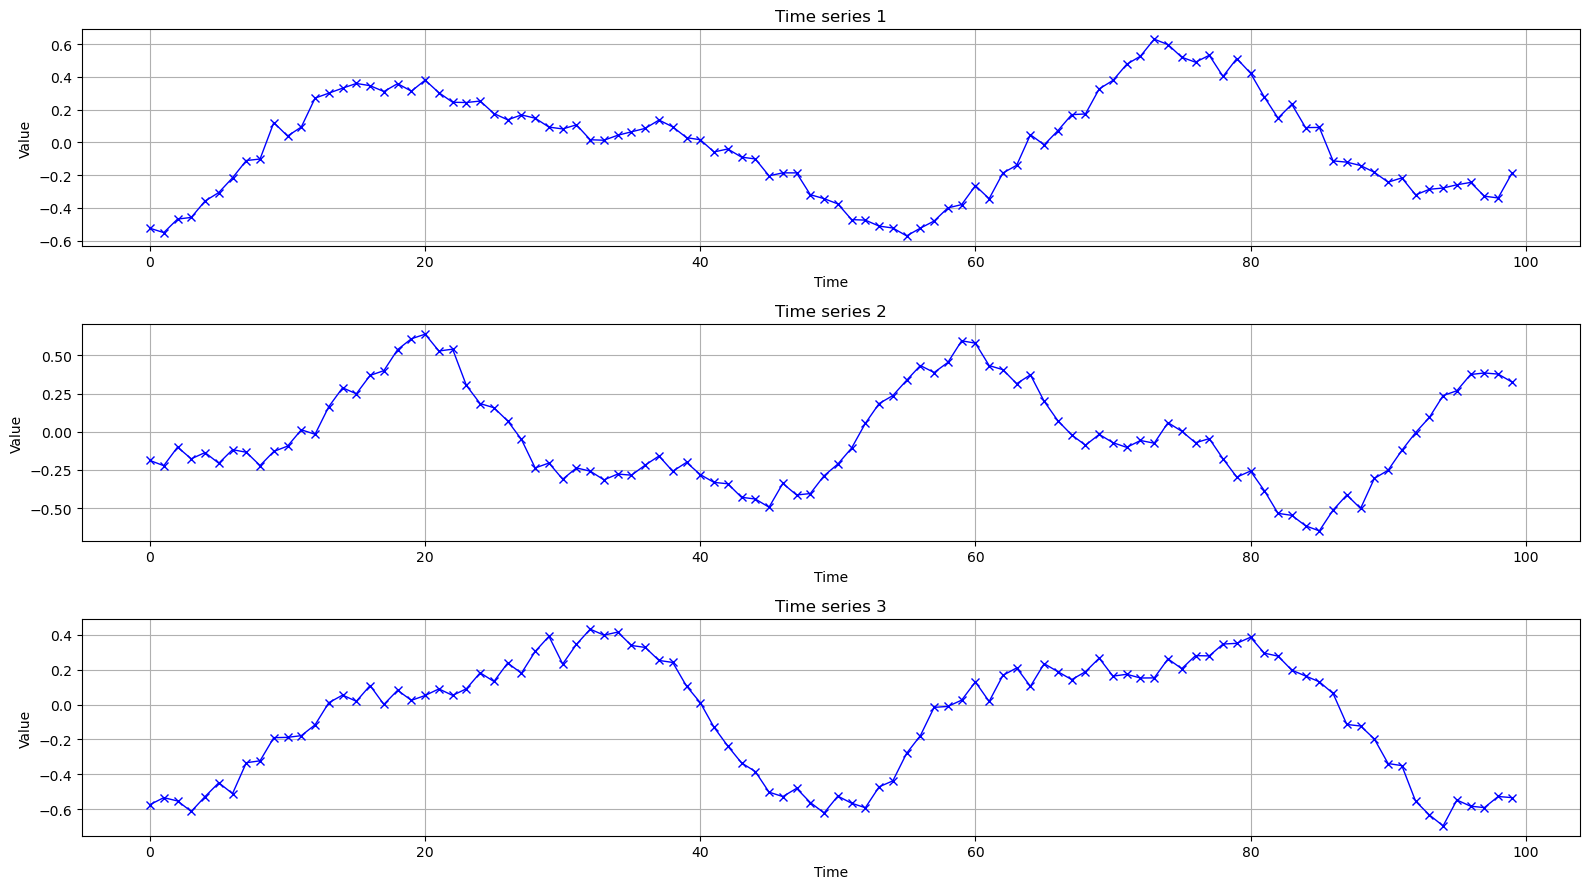

In [8]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [9]:
cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,n_steps:]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,n_steps:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (80, 50)
y_train shape: (80, 50)
X_valid shape: (20, 50)
y_valid shape: (20, 50)


In [10]:
# form datasets, dataloaders, etc

BATCH_SIZE = 16  # 8192 ok sur RTX3080 et 150 time steps

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Baseline : RNN

In [11]:
class RNNModelLookAhead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_ahead=n_ahead, num_layers=1, batch_first=True, device=device, dtype=dtype):
        """Constructor for RNN.

        Args:
            input_dim (_type_): dimensionality of the input
            hidden_dim (_type_): dimensionality of the hidden state
            n_ahead (_type_, optional): number of time steps to predict. Defaults to N_AHEAD.
            output_dim (_type_, optional): dimensionality of the output.
            num_layers (int, optional): number of recurrent layers. Defaults to 1.
            batch_first (bool, optional): whether batch dim is first or not. Defaults to True.
                1. batch_first=True: (batch, seq, feature_dimension)
                2. batch_first=False: (seq, batch, feature_dimension)
            bidirectional (bool, optional): if True, becomes a bidriectional RNN. Defaults to False.
                1. bidirectional=True: num_directions=2, (batch, seq, hidden_dim * 2)
                2. bidirectional=False: num_directions=1, (batch, seq, hidden_dim)
            device (_type_, optional): _description_. Defaults to device.
            dtype (_type_, optional): _description_. Defaults to dtype.
        """
        super(RNNModelLookAhead, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = False
        self.n_ahead = n_ahead
        
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=self.bidirectional
        )
        self.fc = nn.Linear(hidden_dim, n_ahead*output_dim)
    
    def forward(self, x):
        # first, initialize the hidden state
        h0 = torch.zeros((self.num_layers, x.size(0), self.hidden_dim), requires_grad=True).to(device)
        # INPUT : x : (batch, sequence_length, input_feature_dimension)
        x, _ = self.rnn(x, h0) 
        # OUTPUT: 
        # - output : (batch, sequence_length, hidden_dimension * num_directions)
        # - h_n : (num_layers * num_directions, batch, hidden_dimension) (hidden state for last time step)
        x = self.fc(x[:, -1, :])  # take the last time step
        x = x.view(-1, self.n_ahead, self.output_dim)
        # OUTPUT: x : (batch, output_dimension)
        return x

In [12]:
rnn = RNNModelLookAhead(
    input_dim=1,
    output_dim=1,
    n_ahead=n_ahead,
    hidden_dim=128,
    num_layers=4,
    batch_first=True,
    device=device,
    dtype=dtype
).to(device)

print(rnn)

RNNModelLookAhead(
  (rnn): RNN(1, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=50, bias=True)
)


In [13]:
# Test dimensions

x = torch.randn(BATCH_SIZE, 50, 1).to(device)
y = rnn(x)
print(f"input shape: {x.shape}")
print(f"output shape: {y.shape}")

input shape: torch.Size([16, 50, 1])
output shape: torch.Size([16, 50, 1])


In [14]:
criterion = nn.MSELoss()

In [15]:
lr = 1e-4
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
num_epochs = 100

In [16]:
train_losses = []
valid_losses = []

print(f"Start training RNN model for {num_epochs} epochs")

for i in range(num_epochs):
    # loop on training data
    rnn.train()
    optimizer.zero_grad()
    ### loop on training data
    epoch_loss = 0
    for input, target in train_loader:
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        # print(f"input has shape {input.shape}")
        target = target.to(device).view(-1, n_ahead, 1)
        # print(f"target has shape {target.shape}")
        output = rnn(input)
        # print(F"output has shape {output.shape}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader) 
    train_losses.append(epoch_loss)
    
    # test step
    rnn.eval()
    epoch_loss = 0
    with torch.no_grad():
        for input, target in test_loader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            target = target.to(device).view(-1, n_ahead, 1)
            output = rnn(input)
            loss = criterion(output, target)
            epoch_loss += loss.item()
    epoch_loss /= len(test_loader)
    valid_losses.append(epoch_loss)
    
    # report out
    if (i+1) % 5 == 0:
        print(f"epoch {i+1:>4}/{num_epochs}, training loss = {train_losses[-1]:.4e}, validation loss = {valid_losses[-1]:.4e}")

Start training RNN model for 100 epochs
epoch    5/100, training loss = 9.6946e-02, validation loss = 1.0020e-01
epoch   10/100, training loss = 8.1686e-02, validation loss = 7.2523e-02
epoch   15/100, training loss = 6.8094e-02, validation loss = 6.4096e-02
epoch   20/100, training loss = 5.6374e-02, validation loss = 5.4014e-02
epoch   25/100, training loss = 4.9919e-02, validation loss = 5.2378e-02
epoch   30/100, training loss = 4.7469e-02, validation loss = 5.2717e-02
epoch   35/100, training loss = 4.6043e-02, validation loss = 5.3798e-02
epoch   40/100, training loss = 4.5448e-02, validation loss = 4.6956e-02
epoch   45/100, training loss = 4.4617e-02, validation loss = 4.7933e-02
epoch   50/100, training loss = 4.4359e-02, validation loss = 5.1496e-02
epoch   55/100, training loss = 4.5014e-02, validation loss = 4.3133e-02
epoch   60/100, training loss = 4.4367e-02, validation loss = 5.4101e-02
epoch   65/100, training loss = 4.3663e-02, validation loss = 6.2007e-02
epoch   70/

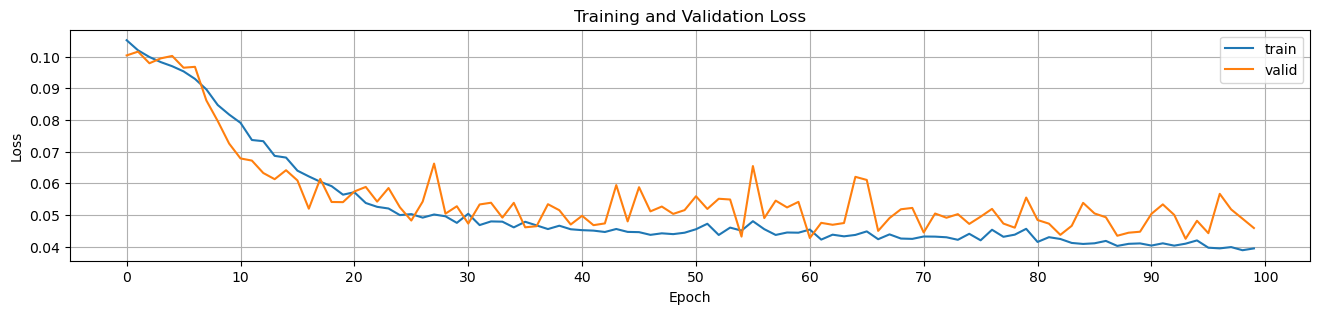

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_xticks(np.arange(0, num_epochs+1, 10))
ax.set_xticklabels(np.arange(0, num_epochs+1, 10))
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss")
ax.grid()
plt.show()

In [18]:
y_pred = rnn(torch.tensor(X_valid).to(device).unsqueeze(-1))
y_target = torch.tensor(y_valid).to(device).unsqueeze(-1)

# print(f"y_target shape: {y_target.shape}")
# print(f"y_pred shape: {y_pred.shape}")

print(f"Loss finale = {criterion(y_pred, y_target):.4e}")

y_pred = y_pred.cpu().detach().numpy()
y_target = y_target.cpu().detach().numpy()

# print(f"\n{np.mean(np.sqrt((y_target - y_pred) ** 2)):.4f} RMSE")

Loss finale = 4.5633e-02


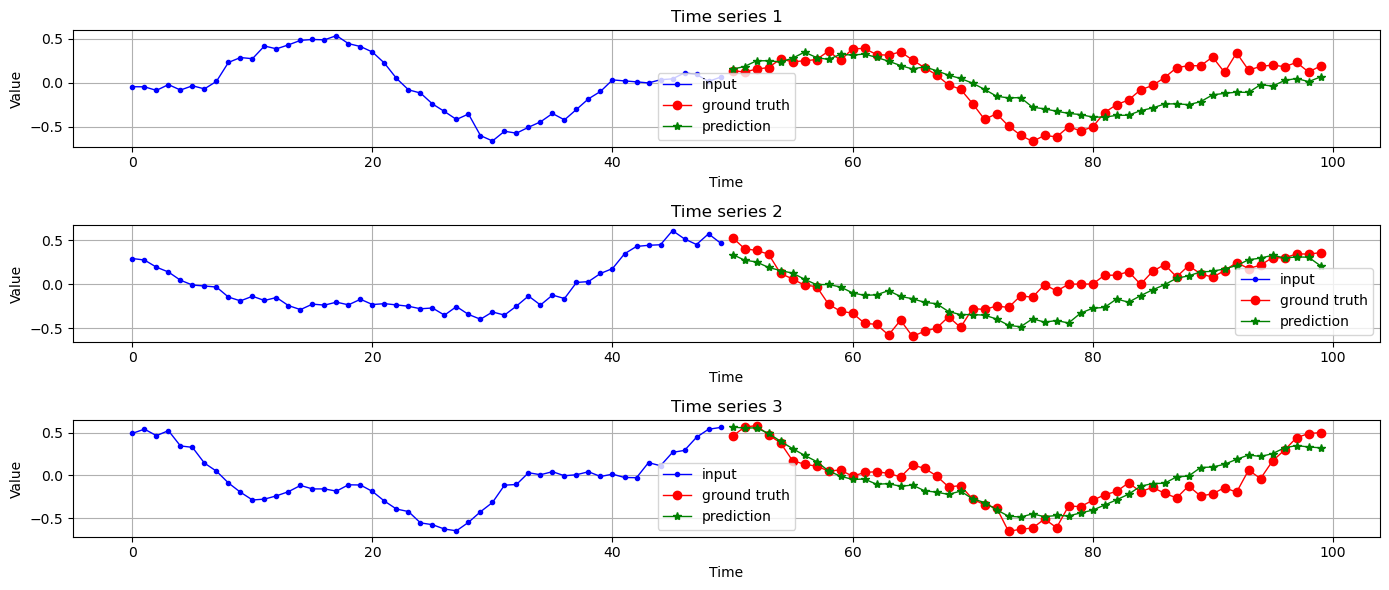

In [19]:
N = 3
fig, ax  = plt.subplots(N, 1, figsize=(14, 2 * N))
x_shift = X_valid.shape[-1]

for i in range(N):
    input = torch.tensor(X_valid[i], device=device).unsqueeze(0).unsqueeze(-1)
    # input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)
    # print(f"input has shape {input.shape}")
    target = torch.tensor(y_valid[i], device=device).view(-1, n_ahead, 1)
    # target = target.permute(1, 0, 2)  # permute to (seq_len, batch_size, output_dim)
    # print(f"target has shape {target.shape}")
    output = rnn(input)
    output = output.cpu().detach().numpy()
    # print(f"output has shape {output.shape}")
    target = target.cpu().detach().numpy()
    
    ax[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker=".", linewidth=1, label="input")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, target.squeeze(), color='red', marker="o", linewidth=1, label="ground truth")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, output.squeeze(), color='green', marker="*", linewidth=1, label="prediction")
    ax[i].set_title(f"Time series {i+1}")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Value")
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()

# Training GP-VAE

https://www.youtube.com/watch?v=rz76gYgxySo&list=WL&index=1&t=1618s&ab_channel=SimonLeglaive

<div>
<img src="/home/benjamin.deporte/MVA/MVA_Stage/GPVAE_schema_bloc.jpg" width="1000"/>
</div>

# Step by Step Training Pipeline

Parameters : univariate time series for now...

In [20]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 1 # Dimension of the latent space

Instantiating the model

In [21]:
encoder = Encoder(
    x_dimension=X_DIM,
    z_dimension=Z_DIM,
).to(device)

decoder = GaussianDecoder(
    x_dimension=X_DIM,
    z_dimension=Z_DIM,
).to(device)

prior = GaussianProcessPriorMaison(
    z_dimension=Z_DIM,
    kernels_list=None,
    mean_functions_list=None
).to(device)

print(encoder)
print()
print(decoder)
print()
print(prior)

Encoder, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU
EncoderMean: EncoderMean, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU
EncoderCovariance: EncoderCovariance, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU, epsilon (to ensure PSD)=1.000e-03

GaussianDecoder, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU
DecoderMean: DecoderMean x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU
DecoderCovariance: DecoderCovariance, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU, epsilon (to ensure PSD)=1.000e-06

GaussianProcessPriorMaison(z_dimension=1, 
Kernels list: [GaussianKernel(lengthscale=1.000e+00, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-03)]
Mean Functions list: [GPNullMean]
Epsilon (added to ensure PSD): 1.000e-03


Taking a batch of time series

In [22]:
B = 16 # batch size
x = X_train[:B,:n_steps].reshape(B, n_steps, X_DIM)
x = torch.tensor(x, device=device) # (B, L, Dx)
print(f"x shape: {x.shape}")

x shape: torch.Size([16, 50, 1])


Encode Time Series

In [23]:
mu_phi, sigma_phi, q_phi = encoder(x)

print(f"mu_phi shape: {mu_phi.shape}")
print(f"sigma_phi shape: {sigma_phi.shape}")
print(f"q_phi: {q_phi}")
print(f"\tq_phi batch shape: {q_phi.batch_shape}")
print(f"\tq_phi event shape: {q_phi.event_shape}")

mu_phi shape: torch.Size([16, 1, 50])
sigma_phi shape: torch.Size([16, 1, 50, 50])
q_phi: MultivariateNormal(loc: torch.Size([16, 1, 50]), scale_tril: torch.Size([16, 1, 50, 50]))
	q_phi batch shape: torch.Size([16, 1])
	q_phi event shape: torch.Size([50])


Sample latent

In [24]:
z_sampled = q_phi.rsample()  # (B, Dz, N)
z_sampled = z_sampled.permute(0, 2, 1)  # (B, N, Dz)
# z_sampled = z_sampled.unsqueeze(2) # (B, L, Dz)
print(f"(permuted) z_sampled shape: {z_sampled.shape}")

(permuted) z_sampled shape: torch.Size([16, 50, 1])


Decode the latent and sample $K$ x's

In [25]:
mu_x, sigma_x, p_theta_x = decoder(z_sampled)

print(f"mu_x shape: {mu_x.shape}")
print(f"sigma_x shape: {sigma_x.shape}")
print(f"p_theta_x: {p_theta_x}")
print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}")
print(f"\tp_theta_x event shape: {p_theta_x.event_shape}")

mu_x shape: torch.Size([16, 50, 1])
sigma_x shape: torch.Size([16, 50, 1, 1])
p_theta_x: MultivariateNormal(loc: torch.Size([16, 50, 1]), scale_tril: torch.Size([16, 50, 1, 1]))
	p_theta_x batch shape: torch.Size([16, 50])
	p_theta_x event shape: torch.Size([1])


In [26]:
K = 10 # number of samples to draw from the decoder distribution
x_hat = p_theta_x.rsample((K,))  # (K, B, L, Dx)
print(f"x_hat shape ({K} samples): {x_hat.shape}")

x_hat shape (10 samples): torch.Size([10, 16, 50, 1])


Compute the Gaussian Process prior at times t's

In [27]:
t = torch.arange(n_steps, device=device).unsqueeze(0)  # (1, N)
t = t.repeat(B, 1)  # (B, N)

print(f"t shape: {t.shape}")

mu_z, sigma_z, p_theta_z = prior(t)

print(f"mu_z shape: {mu_z.shape}")
print(f"sigma_z shape: {sigma_z.shape}")
print(f"p_theta_z: {p_theta_z}")
print(f"\tp_theta_z batch shape: {p_theta_z.batch_shape}")
print(f"\tp_theta_z event shape: {p_theta_z.event_shape}")

t shape: torch.Size([16, 50])
mu_z shape: torch.Size([16, 1, 50])
sigma_z shape: torch.Size([16, 1, 50, 50])
p_theta_z: MultivariateNormal(loc: torch.Size([16, 1, 50]), scale_tril: torch.Size([16, 1, 50, 50]))
	p_theta_z batch shape: torch.Size([16, 1])
	p_theta_z event shape: torch.Size([50])


Compute the metrics and the loss

In [28]:
kl_divergence_torch, kl_divergence_analytique, reconstruction_loss, vlb_value = compute_vlb(
    q_phi, p_theta_x, p_theta_z, x_hat
)

loss = -vlb_value
print(f"Loss : {loss.item():.4e}")

Loss : 1.1956e+03


# Full Training Loop - show overfitting and mode collapse

In [87]:
Z_DIM = 16

In [90]:
encoder = Encoder(
    x_dimension=X_DIM,
    z_dimension=Z_DIM,
).to(device)

decoder = GaussianDecoder(
    x_dimension=X_DIM,
    z_dimension=Z_DIM,
).to(device)

prior = GaussianProcessPriorMaison(
    z_dimension=Z_DIM,
    kernels_list=None,
    mean_functions_list=None
).to(device)

print(encoder)
print()
print(decoder)
print()
print(prior)
print()

B = 16 # batch size : B=512 for T=100 for example
x = X_train[:B,:n_steps].reshape(B, n_steps, X_DIM)
x = torch.tensor(x, device=device) # (B, L, 1)
print(f"x shape: {x.shape}")

t = torch.arange(n_steps, device=device).unsqueeze(0)  # (1, N)
t = t.repeat(B, 1)  # (B, N)
print(f"t shape: {t.shape}")

Encoder, x_dimension=1, z_dimension=16, n_layers=3, inter_dim=128, activation=ReLU
EncoderMean: EncoderMean, x_dimension=1, z_dimension=16, n_layers=3, inter_dim=128, activation=ReLU
EncoderCovariance: EncoderCovariance, x_dimension=1, z_dimension=16, n_layers=3, inter_dim=128, activation=ReLU, epsilon (to ensure PSD)=1.000e-03

GaussianDecoder, x_dimension=1, z_dimension=16, n_layers=3, inter_dim=128, activation=ReLU
DecoderMean: DecoderMean x_dimension=1, z_dimension=16, n_layers=3, inter_dim=128, activation=ReLU
DecoderCovariance: DecoderCovariance, x_dimension=1, z_dimension=16, n_layers=3, inter_dim=128, activation=ReLU, epsilon (to ensure PSD)=1.000e-06

GaussianProcessPriorMaison(z_dimension=16, 
Kernels list: [GaussianKernel(lengthscale=1.000e+00, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-03), GaussianKernel(lengthscale=1.000e+00, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-03), GaussianKernel(lengthscale=1.000e+00, variance (sigma**2)=1.

In [91]:
# Training set up
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()) + list(prior.parameters()),
    lr=1e-4
)

K = 10  # number of samples to draw from the decoder distribution

# Training loop
encoder.train()
decoder.train()
prior.train()

losses = []
kls_torch = []
kls_analytique = []
reconstruction_losses = []
kernel_lengthscales = []
kernel_variances = []
traces_sigma_q_phi = []
sigma_phi_min_eigvals = []
sigma_phi_max_eigvals = []

norms_mu_phi = []
norms_mu_x = []
sigma_x_min_eigvals = []
sigma_x_max_eigvals = []
traces_sigma_x = []
    
num_epochs = int(1e+3)
# beta = 1.0

for i in range(num_epochs):
    
    # encode x
    # print(f"x shape: {x.shape}")
    mu_phi, sigma_phi, q_phi = encoder(x)
    
    # print(f"mu_phi shape: {mu_phi.shape}")
    # print(f"sigma_phi shape: {sigma_phi.shape}")
    # print(f"q_phi: {q_phi}")
    # print(f"\tq_phi batch shape: {q_phi.batch_shape}")
    # print(f"\tq_phi event shape: {q_phi.event_shape}")
    
    # log q_phi caracteristics
    sigma_q_phi_eigvals = torch.linalg.eigvals(sigma_phi)  # eigenvalues of the covariance matrix (B, L)
    sigma_phi_min_eigvals.append(sigma_q_phi_eigvals.real.min(dim=1).values.mean().item())  # min eigenvalue of the covariance matrix
    sigma_phi_max_eigvals.append(sigma_q_phi_eigvals.real.max(dim=1).values.mean().item())  # max eigenvalue of the covariance matrix
    trace_sigma_q_phi = torch.einsum('...ii->', sigma_phi).mean()  # trace of the covariance matrix, used for diagnostics
    traces_sigma_q_phi.append(trace_sigma_q_phi.item())
    norm_mu_phi = torch.norm(mu_phi, dim=1).mean()  # mean of the norm of mu_phi
    norms_mu_phi.append(norm_mu_phi.item())
    
    # sample z
    z_sampled = q_phi.rsample()  # (B, L)
    z_sampled = z_sampled.permute(0, 2, 1)  # (B, N, Dz)
    # z_sampled = z_sampled.unsqueeze(2) # (B, L, Dz)
    # print(f"(permuted) z_sampled shape: {z_sampled.shape}")
    
    # decode z
    mu_x, sigma_x, p_theta_x = decoder(z_sampled)
    # print(f"mu_x shape: {mu_x.shape}")
    # print(f"sigma_x shape: {sigma_x.shape}")
    # print(f"p_theta_x: {p_theta_x}")
    # print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}")
    # print(f"\tp_theta_x event shape: {p_theta_x.event_shape}")
    
    # log p_theta_x caracteristics
    norm_mu_x = torch.norm(mu_x, dim=1).mean()  # mean of the norm of mu_x
    norms_mu_x.append(norm_mu_x.item())
    sigma_x_eigvals = torch.linalg.eigvals(sigma_x)  # eigenvalues of the covariance matrix (B, L)
    sigma_x_min_eigvals.append(sigma_x_eigvals.real.min(dim=1).values.mean().item())  # min eigenvalue of the covariance matrix
    sigma_x_max_eigvals.append(sigma_x_eigvals.real.max(dim=1).values.mean().item())  # max eigenvalue of the covariance matrix
    trace_sigma_x = torch.einsum('...ii->', sigma_x).mean()  # trace of the covariance matrix, used for diagnostics
    traces_sigma_x.append(trace_sigma_x.item())
    
    # sample from p_theta_x
    x_hat = p_theta_x.rsample((K,))  # (K, B, L, Dx)
    # print(f"x_hat shape ({K} samples): {x_hat.shape}")
    
    # compute prior
    mu_z, sigma_z, p_theta_z = prior(t)
    
    # compute loss
    kl_divergence_torch, kl_divergence_analytique, reconstruction_loss, vlb_value = compute_vlb(
        q_phi, p_theta_x, p_theta_z, x_hat
    )
    loss = -vlb_value
    # loss = -reconstruction_loss + beta * kl_divergence_torch  # reconstruction loss + KL divergence
    
    # add regularization on size of q_phi
    # size_of_q_phi = trace_sigma_q_phi + norm_mu_phi # compute the "size" of q_phi
    # loss += size_of_q_phi  # add regularization on size of q_phi
    
    # log losses
    losses.append(loss.item())
    kls_torch.append(kl_divergence_torch.item())
    # kls_analytique.append(kl_divergence_analytique.item())
    # changing sign of reconstruction loss as it is an expectation of the log likelihood
    reconstruction_losses.append(-reconstruction_loss.item())
    # # get kernel parameters, they are learnable
    # kernel_lengthscale = prior.kernel.lengthscale.item()
    # kernel_lengthscales.append(kernel_lengthscale)
    # kernel_variance = prior.kernel.variance.item()
    # kernel_variances.append(kernel_variance)
    
    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # report out
    if (i+1) % 10 == 0:
        print(f"epoch {i+1:>4}/{num_epochs}, loss = {losses[-1]:.4e}, "
              f"kl_torch = {kls_torch[-1]:.4e}, "
              f"reconstruction_loss = {reconstruction_losses[-1]:.4e}, "
            #   f"GP kernel lengthscale = {kernel_lengthscale:.4e}, "
            #   f"GP kernel variance = {kernel_variance:.4e}"
              )

epoch   10/1000, loss = 1.7749e+04, kl_torch = 1.7680e+04, reconstruction_loss = 6.8379e+01, 
epoch   20/1000, loss = 1.6053e+04, kl_torch = 1.5989e+04, reconstruction_loss = 6.3936e+01, 
epoch   30/1000, loss = 1.4430e+04, kl_torch = 1.4371e+04, reconstruction_loss = 5.9305e+01, 
epoch   40/1000, loss = 1.2904e+04, kl_torch = 1.2852e+04, reconstruction_loss = 5.2079e+01, 
epoch   50/1000, loss = 1.1548e+04, kl_torch = 1.1501e+04, reconstruction_loss = 4.6957e+01, 
epoch   60/1000, loss = 1.0375e+04, kl_torch = 1.0336e+04, reconstruction_loss = 3.9010e+01, 
epoch   70/1000, loss = 9.4004e+03, kl_torch = 9.3693e+03, reconstruction_loss = 3.1103e+01, 
epoch   80/1000, loss = 8.5951e+03, kl_torch = 8.5726e+03, reconstruction_loss = 2.2455e+01, 
epoch   90/1000, loss = 7.9204e+03, kl_torch = 7.9028e+03, reconstruction_loss = 1.7577e+01, 
epoch  100/1000, loss = 7.3466e+03, kl_torch = 7.3398e+03, reconstruction_loss = 6.7963e+00, 
epoch  110/1000, loss = 6.8878e+03, kl_torch = 6.8802e+03, r

ValueError: Expected parameter loc (Tensor of shape (16, 16, 50)) of distribution MultivariateNormal(loc: torch.Size([16, 16, 50]), scale_tril: torch.Size([16, 16, 50, 50])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='cuda:0',
       grad_fn=<ExpandBackward0>)

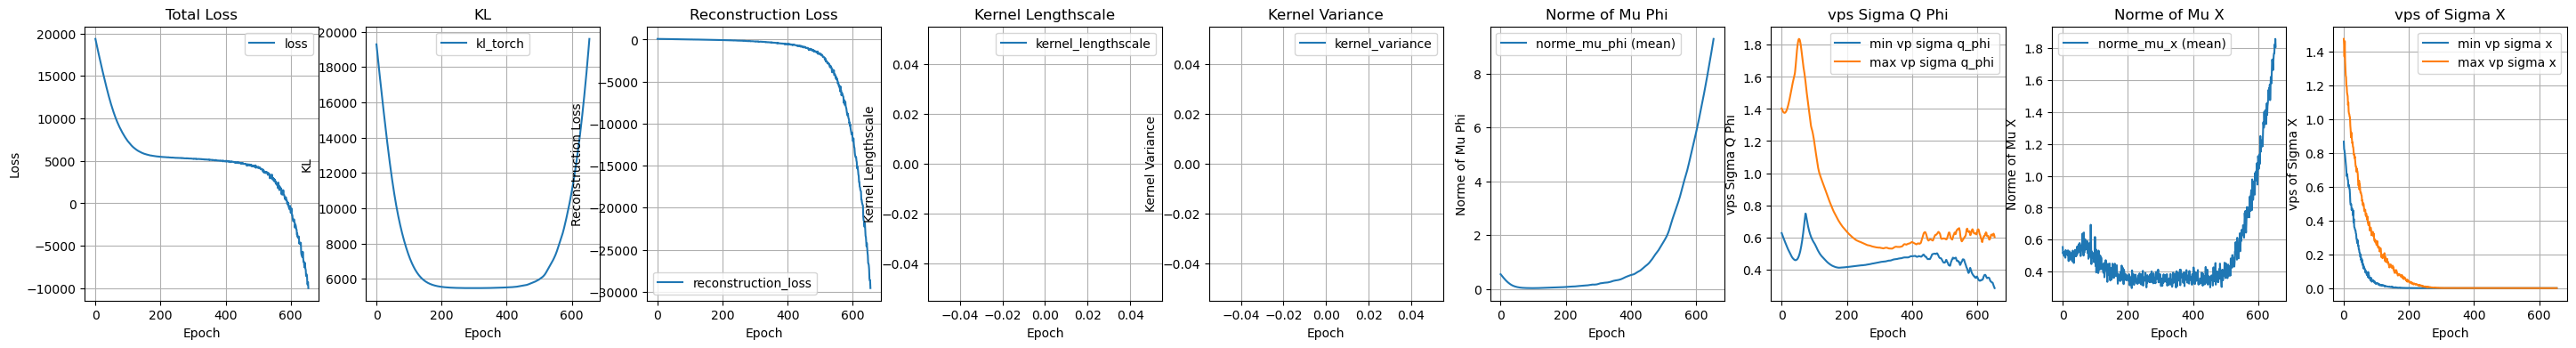

In [92]:
fig, ax = plt.subplots(1, 9, figsize=(36, 4))

ax[0].plot(losses, label="loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Total Loss")
ax[0].grid()
ax[0].legend()

ax[1].plot(kls_torch, label="kl_torch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("KL")
ax[1].set_title("KL")
ax[1].grid()
ax[1].legend()

# ax[1].plot(kls_analytique, label="kl_analytique")
# ax[1].set_xlabel("Epoch")
# ax[1].set_ylabel("KL Divergence (analytique)")
# ax[1].set_title("KL Divergence (analytique) over epochs")
# ax[1].grid()
# ax[1].legend()

ax[2].plot(reconstruction_losses, label="reconstruction_loss")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Reconstruction Loss")
ax[2].set_title("Reconstruction Loss")
ax[2].grid()
ax[2].legend()

ax[3].plot(kernel_lengthscales, label="kernel_lengthscale")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Kernel Lengthscale")
ax[3].set_title("Kernel Lengthscale")
ax[3].grid()
ax[3].legend()

ax[4].plot(kernel_variances, label="kernel_variance")
ax[4].set_xlabel("Epoch")
ax[4].set_ylabel("Kernel Variance")
ax[4].set_title("Kernel Variance")
ax[4].grid()
ax[4].legend()

ax[5].plot(norms_mu_phi, label="norme_mu_phi (mean)")
ax[5].set_xlabel("Epoch")
ax[5].set_ylabel("Norme of Mu Phi")
ax[5].set_title("Norme of Mu Phi")
ax[5].grid()
ax[5].legend()

ax[6].plot(sigma_phi_min_eigvals, label="min vp sigma q_phi")
ax[6].plot(sigma_phi_max_eigvals, label="max vp sigma q_phi")
ax[6].set_xlabel("Epoch")
ax[6].set_ylabel("vps Sigma Q Phi")
ax[6].set_title("vps Sigma Q Phi")
ax[6].grid()
ax[6].legend()

ax[7].plot(norms_mu_x, label="norme_mu_x (mean)")
ax[7].set_xlabel("Epoch")
ax[7].set_ylabel("Norme of Mu X")
ax[7].set_title("Norme of Mu X")
ax[7].grid()
ax[7].legend()

ax[8].plot(sigma_x_min_eigvals, label="min vp sigma x")
ax[8].plot(sigma_x_max_eigvals, label="max vp sigma x")
ax[8].set_xlabel("Epoch")
ax[8].set_ylabel("vps of Sigma X")
ax[8].set_title("vps of Sigma X")
ax[8].grid()
ax[8].legend()

plt.show()

# Training with validation set

In [36]:
# form datasets, dataloaders, etc
batch_size = 16

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [37]:
# Training step

def train_step(
    encoder,
    decoder,
    prior,
    train_dataloader,
    K = 1,
):
    """Training step for the GP-VAE model.

    Args:
        encoder (Encoder): Encoder model.
        decoder (GaussianDecoder): Decoder model.
        prior (GaussianProcessPriorMaison): Prior model.
        train_dataloader (DataLoader): DataLoader for training data.
        K (int): Number of samples to draw from the decoder distribution.

    Returns:
        tuple: Average loss, KL divergence, and reconstruction loss for the training step.
    """
    encoder.train()
    decoder.train()
    prior.train()
    
    epoch_loss = 0
    kl_loss = 0
    reconstruction_loss = 0
    
    for input, target in train_dataloader:
        
        # load data - NB we will not use target, as this will be used for prediction only
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        # target = target.to(device).view(-1, n_ahead, 1)
        
        # encode x
        mu_phi, sigma_phi, q_phi = encoder(input)
        
        # sample z
        z_sampled = q_phi.rsample()  # (B, L)
        z_sampled = z_sampled.unsqueeze(2)  # (B, L, 1)
        
        # decode z
        mu_x, sigma_x, p_theta_x = decoder(z_sampled)
        
        # sample from p_theta_x
        xs_hat = p_theta_x.rsample((K,))  # (K, B, L, 1)
        
        # compute prior
        n_steps = input.size(1)  # sequence length L
        mu_z, sigma_z, p_theta_z = prior(torch.arange(n_steps, device=device).unsqueeze(0).unsqueeze(2).repeat(input.size(0), 1, 1))
        
        # compute loss
        kl_batch, _, reconstruction_loss_batch, vlb_value_batch = vlb(
            q_phi, p_theta_x, p_theta_z, xs_hat
        )
        
        loss_batch = -vlb_value_batch
        
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
        
        epoch_loss += loss_batch.item()
        kl_loss += kl_batch.item()
        reconstruction_loss += reconstruction_loss_batch.item()
    
    epoch_loss /= len(train_dataloader)
    kl_loss /= len(train_dataloader)
    reconstruction_loss /= len(train_dataloader)
    
    return epoch_loss, kl_loss, -reconstruction_loss

In [38]:
# Validation step

def validation_step(
    encoder,
    decoder,
    prior,
    valid_dataloader,
    K = 1,
):
    """Validation step for the GP-VAE model.

    Args:
        encoder (Encoder): Encoder model.
        decoder (GaussianDecoder): Decoder model.
        prior (GaussianProcessPriorMaison): Prior model.
        valid_dataloader (DataLoader): DataLoader for validation data.
        K (int): Number of samples to draw from the decoder distribution.

    Returns:
        tuple: Average loss, KL divergence, and reconstruction loss for the validation step.
    """
    encoder.eval()
    decoder.eval()
    prior.eval()
    
    epoch_loss = 0
    kl_loss = 0
    reconstruction_loss = 0
    
    with torch.no_grad():
        for input, target in valid_dataloader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            
            # encode x
            mu_phi, sigma_phi, q_phi = encoder(input)
            
            # sample z
            z_sampled = q_phi.rsample()  # (B, L)
            z_sampled = z_sampled.unsqueeze(2)  # (B, L, 1)
            
            # decode z
            mu_x, sigma_x, p_theta_x = decoder(z_sampled)
            
            # sample from p_theta_x
            xs_hat = p_theta_x.rsample((K,))  # (K, B, L, 1)
            
            # compute prior
            n_steps = input.size(1)  # sequence length L
            mu_z, sigma_z, p_theta_z = prior(torch.arange(n_steps, device=device).unsqueeze(0).unsqueeze(2).repeat(input.size(0), 1, 1))
            
            # compute loss
            kl_batch, _, reconstruction_loss_batch, vlb_value_batch = vlb(
                q_phi, p_theta_x, p_theta_z, xs_hat
            )
            
            loss_batch = -vlb_value_batch
            
            epoch_loss += loss_batch.item()
            kl_loss += kl_batch.item()
            reconstruction_loss += reconstruction_loss_batch.item()
    
    epoch_loss /= len(valid_dataloader)
    kl_loss /= len(valid_dataloader)
    reconstruction_loss /= len(valid_dataloader)
    
    return epoch_loss, kl_loss, -reconstruction_loss

In [39]:
# Training parameters

num_epochs = 30 # number of epochs to train the model
K = 10  # number of samples to draw from the decoder distribution
learning_rate = 1e-4

In [40]:

# set up

encoder = Encoder(
    sequence_length=n_steps,
    x_dimension=X_DIM,
    z_dimension=Z_DIM,
    activation=nn.ReLU,  # use tanh activation for the encoder
).to(device)

decoder = GaussianDecoder(
    sequence_length=n_steps,
    x_dimension=X_DIM,
    z_dimension=Z_DIM,
    activation=nn.ReLU,  # use tanh activation for the decoder
).to(device)

prior = GaussianProcessPriorMaison(
    kernel=CauchyKernel()
    ).to(device)

print(encoder)
print()
print(decoder)
print()
print(prior)
print()

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()) + list(prior.parameters()),
    lr=learning_rate
)

TypeError: Encoder.__init__() got an unexpected keyword argument 'sequence_length'

In [ ]:
train_losses = []
valid_losses = []

kls_train = []
kls_valid = []

reconstruction_losses_train = []
reconstruction_losses_valid = []

In [ ]:
# Main training loop

for epoch in range(num_epochs):
    
    epoch_loss, kl_loss, reconstruction_loss = train_step(
        encoder,
        decoder,
        prior,
        train_loader,
        K=K
    )
    
    train_losses.append(epoch_loss)
    kls_train.append(kl_loss)
    reconstruction_losses_train.append(reconstruction_loss)
    
    epoch_loss_valid, kl_loss_valid, reconstruction_loss_valid = validation_step(
        encoder,
        decoder,
        prior,
        test_loader,
        K=K
    )
    
    valid_losses.append(epoch_loss_valid)
    kls_valid.append(kl_loss_valid)
    reconstruction_losses_valid.append(reconstruction_loss_valid)
    
    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch + 1:>5}/{num_epochs:>5}, "
              f"Train Loss: {train_losses[-1]:.4e}, "
              f"Valid Loss: {valid_losses[-1]:.4e}, "
              f"Train KL: {kls_train[-1]:.4e}, "
              f"Valid KL: {kls_valid[-1]:.4e}, "
              f"Train Reconstruction Loss: {reconstruction_losses_train[-1]:.4e}, "
              f"Valid Reconstruction Loss: {reconstruction_losses_valid[-1]:.4e}")

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].plot(train_losses, label="Train Loss")
ax[0].plot(valid_losses, label="Valid Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training and Validation Loss")
ax[0].grid()
ax[0].legend()

ax[1].plot(kls_train, label="Train KL")
ax[1].plot(kls_valid, label="Valid KL")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("KL Divergence")
ax[1].set_title("Training and Validation KL Divergence")
ax[1].grid()
ax[1].legend()

ax[2].plot(reconstruction_losses_train, label="Train Reconstruction Loss")
ax[2].plot(reconstruction_losses_valid, label="Valid Reconstruction Loss")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Reconstruction Loss")
ax[2].set_title("Training and Validation Reconstruction Loss")
ax[2].grid()
ax[2].legend()

plt.show()

# Prédictions

In [ ]:
N_SAMPLES = 3  # number of samples to plot

# idx = np.random.choice(len(X_valid), N_SAMPLES)
X_valid_samples = X_valid[idx]
y_valid_samples = y_valid[idx]

fig, axs = plt.subplots(N_SAMPLES, 1, figsize=(16, 3 * N_SAMPLES))

for i in range(N_SAMPLES):
    input = torch.tensor(X_valid_samples[i], device=device).unsqueeze(1).unsqueeze(2).permute(1, 0, 2)  # (1, L, Dx)
    target = torch.tensor(y_valid_samples[i], device=device).unsqueeze(1).unsqueeze(2).permute(1, 0, 2)  # (1, L, Dx)
    
    # print(f"input shape : {input.shape}")
    # print(f"target shape: {target.shape}")
    
    total_length = input.size(1) # + target.size(1)
    ts = torch.arange(total_length, device=device).unsqueeze(0).unsqueeze(2).repeat(input.size(0), 1, 1)  # (B, L, 1)
    ts = ts.double()
    
    mu_z, sigma_z, p_theta_z = prior(ts)
    
    # print(f"mu_z shape: {mu_z.shape}")
    # print(f"sigma_z shape: {sigma_z.shape}")
    # print(f"p_theta_z: {p_theta_z}")
    # print(f"p_theta_z batch shape: {p_theta_z.batch_shape}")
    # print(f"p_theta_z event shape: {p_theta_z.event_shape}")
    
    
    # sample from the prior
    z_sampled = p_theta_z.rsample()  # (B, L, Dz)
    z_sampled = z_sampled.unsqueeze(2)  # (B, L, 1)
    
    # print(f"z_sampled shape: {z_sampled.shape}")
    
    # then sample from the decoder
    mu_x, sigma_x, p_theta_x = decoder(z_sampled)
    # print(f"mu_x shape: {mu_x.shape}")
    # print(f"sigma_x shape: {sigma_x.shape}")
    # print(f"p_theta_x: {p_theta_x}")
    # print(f"p_theta_x batch shape: {p_theta_x.batch_shape}")
    # print(f"p_theta_x event shape: {p_theta_x.event_shape}")
    
    # display data
    
    inputs = input.squeeze().cpu().detach().numpy()
    # print(inputs)
    preds = mu_x.squeeze().cpu().detach().numpy()
    # print(preds)
    
    axs[i].plot(inputs, color='blue', marker=".", linewidth=1, label="ground truth input")
    axs[i].plot(preds, color='red', marker="o", linewidth=1, label="mu_x (decoder output)")
    axs[i].legend()
    axs[i].grid()
    
    # target = torch.tensor(y_valid_subset[i], device=device)
    # target = target.cpu().detach().numpy()
    
    # mu_predictions, logvar_predictions, mu_full_x, logvar_full_x = model.predict(input, n_ahead)
              
    #     # display data
    #     axs[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker=".", linewidth=1, label="input")
    #     axs[i].plot(np.arange(len(target))+n_steps, target, color='red', marker="o", linewidth=1, label="ground truth")
        
    #     # display predictions and credible intervals
    #     all_times = np.arange(n_steps+n_ahead)
    #     mu_full_x = mu_full_x.squeeze().cpu().detach().numpy()
    #     logvar_full_x = logvar_full_x.squeeze().cpu().detach().numpy()
    #     std_full_x = np.exp(logvar_full_x / 2)
        
    #     axs[i].scatter(all_times, mu_full_x, color='green', marker="x", linewidth=1, label="reconstructed and predicted")
    #     axs[i].fill_between(all_times, mu_full_x-2*std_full_x, mu_full_x+2*std_full_x, color='orange', label='+/- 2 std', alpha=0.2)
        
    #     axs[i].set_title(f"Time series {idx[i]}")
    #     axs[i].set_xlabel("Time")
    #     axs[i].set_ylabel("Value")
    #     axs[i].legend()
    #     axs[i].grid(True)
        
plt.tight_layout()
plt.show()